# Training RelateAnything with PSG

In [1]:
%load_ext autoreload
%autoreload 2

from segment_anything import build_sam, SamPredictor, SamAutomaticMaskGenerator

Bad pipe message: %s [b'\x08\xae\xd7\xd6\x1c\xee\x13\x7f\tn\x089']
Bad pipe message: %s [b"\xa0\x15\xf0M\x91\xb6\x0c\xf3\x9c\xe6\xaf\xb5\x9fxB\x19\xd0\x8b\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04"]
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s [b"\xef\xe6\xb1\xfc\x9d\xf0f\xbb\

In [2]:
predictor = SamPredictor(build_sam(checkpoint="./segment_anything/checkpoints/sam_vit_h_4b8939.pth"))
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="./segment_anything/checkpoints/sam_vit_h_4b8939.pth"))

### Get PSG Dataset

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pprint

import numpy as np

from openpsg.utils.vis_tools.datasets import coco_dir
from openpsg.utils.vis_tools.preprocess import load_json

from detectron2.data.detection_utils import read_image
from detectron2.utils.colormap import colormap
from panopticapi.utils import rgb2id

def get_colormap(num_colors: int):
    return (np.resize(colormap(), (num_colors, 3))).tolist()

In [4]:
# set working path as home dir to easy access data
psg_dataset_file = load_json(Path("data/psg/psg.json"))
print('keys: ', list(psg_dataset_file.keys()))

psg_thing_cats = psg_dataset_file['thing_classes']
psg_stuff_cats = psg_dataset_file['stuff_classes']
psg_obj_cats = psg_thing_cats + psg_stuff_cats
psg_rel_cats = psg_dataset_file['predicate_classes']
psg_dataset = {d["image_id"]: d for d in psg_dataset_file['data']}
# psg_dataset_coco_id = {d["coco_image_id"]: d for d in psg_dataset_file['data']}

print('Number of images: {}'.format(len(psg_dataset)))
print('# Object Classes: {}'.format(len(psg_obj_cats)))
print('# Relation Classes: {}'.format(len(psg_rel_cats)))

keys:  ['data', 'thing_classes', 'stuff_classes', 'predicate_classes', 'test_image_ids']
Number of images: 48749
# Object Classes: 133
# Relation Classes: 56


In [5]:
example_img_id = '2346957'
data = psg_dataset[example_img_id]
data['relations']

[[0, 10, 3],
 [1, 10, 3],
 [3, 10, 3],
 [5, 10, 3],
 [6, 10, 3],
 [7, 10, 3],
 [8, 10, 3],
 [11, 12, 3],
 [13, 12, 2]]

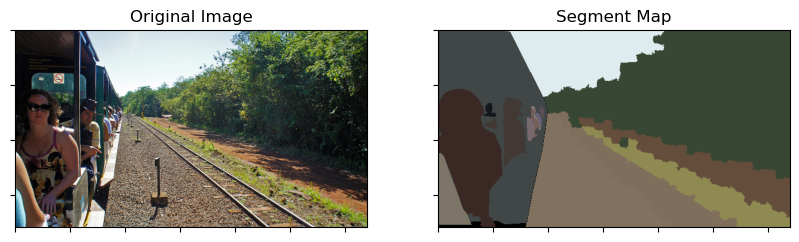

Segments IDs:  [       0  1840916  2369594  3422274  3425848  3886692  4408387  4671041
  5409167  5787738  5857142  5992062  6254977  6911358  7235960  8020586
  8027265 15723743]
Segments Annotations: 
[{'area': 3927,
  'attribute_ids': [],
  'category_id': 0,
  'gqa_category_id': 868,
  'id': 3422274,
  'iscrowd': 0,
  'isthing': 1},
 {'area': 477,
  'attribute_ids': [46],
  'category_id': 0,
  'gqa_category_id': 1298,
  'id': 7235960,
  'iscrowd': 0,
  'isthing': 1},
 {'area': 127, 'category_id': 0, 'id': 8020586, 'iscrowd': 0, 'isthing': 1},
 {'area': 126, 'category_id': 0, 'id': 5787738, 'iscrowd': 0, 'isthing': 1},
 {'area': 87, 'category_id': 0, 'id': 4408387, 'iscrowd': 0, 'isthing': 1},
 {'area': 18499,
  'attribute_ids': [],
  'category_id': 0,
  'gqa_category_id': 800,
  'id': 2369594,
  'iscrowd': 0,
  'isthing': 1},
 {'area': 313, 'category_id': 0, 'id': 5857142, 'iscrowd': 0, 'isthing': 1},
 {'area': 112, 'category_id': 0, 'id': 8027265, 'iscrowd': 0, 'isthing': 1},
 {'a

In [6]:
# show origin image
image = read_image(coco_dir / data["file_name"], format="RGB")
seg_map = read_image(coco_dir / data["pan_seg_file_name"], format="RGB")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(seg_map)
axs[1].set_title("Segment Map")

# Hide the x and y axis labels for both subplots
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the subplots
plt.show()

# show seg annotations
seg_map = rgb2id(seg_map)
print('Segments IDs: ', np.unique(seg_map))
print('Segments Annotations: ')
pprint.pprint(data["segments_info"])

In [7]:
# get seperate masks
gt_masks = []
labels_coco = []
for i, s in enumerate(data["segments_info"]):
    label = psg_obj_cats[s["category_id"]]
    labels_coco.append(label)
    gt_masks.append(seg_map == s["id"])

In [8]:
from PIL import Image
pilimage = Image.open(coco_dir / data["file_name"])
width, height = pilimage.size
full_area = width * height

### Segment Everything

In this part, we have sam_feats as all masks features.

In [12]:
sam_masks = mask_generator.generate(image)

/mnt/lustre/jkyang/PSG4D/RelateAnything/segment_anything/segment_anything/utils/amg.py:118: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729009598/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  change_indices = diff.nonzero()


In [14]:
sam_masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'feat'])

In [15]:
filtered_masks = [d for d in sam_masks if d['area'] > 0.03 * full_area]
print('number of masks left:', len(filtered_masks))

number of masks left: 9


In [16]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def sort_and_deduplicate(sam_masks, iou_threshold=0.8):
    # Sort the sam_masks list based on the area value
    sorted_masks = sorted(sam_masks, key=lambda x: x['area'], reverse=True)

    # Deduplicate masks based on the given iou_threshold
    filtered_masks = []
    for mask in sorted_masks:
        duplicate = False
        for filtered_mask in filtered_masks:
            if iou(mask['segmentation'], filtered_mask['segmentation']) > iou_threshold:
                duplicate = True
                break

        if not duplicate:
            filtered_masks.append(mask)

    return filtered_masks

# Example usage
filtered_masks = sort_and_deduplicate(filtered_masks)
print('number of masks left:', len(filtered_masks))

number of masks left: 8


In [17]:
ddup_masks = sort_and_deduplicate(sam_masks)
print('number of deduplicated masks:', len(ddup_masks))

number of deduplicated masks: 60


In [18]:
def show_anns(anns, color='auto'):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        if color == 'auto':
            for i in range(3):
                img[:,:,i] = color_mask[i]
        else:
            for i in range(3):
                img[:,:,0] = 1
                img[:,:,1] = 0
                img[:,:,2] = 0
    return np.dstack((img, m*0.35))

In [19]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', 
               s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

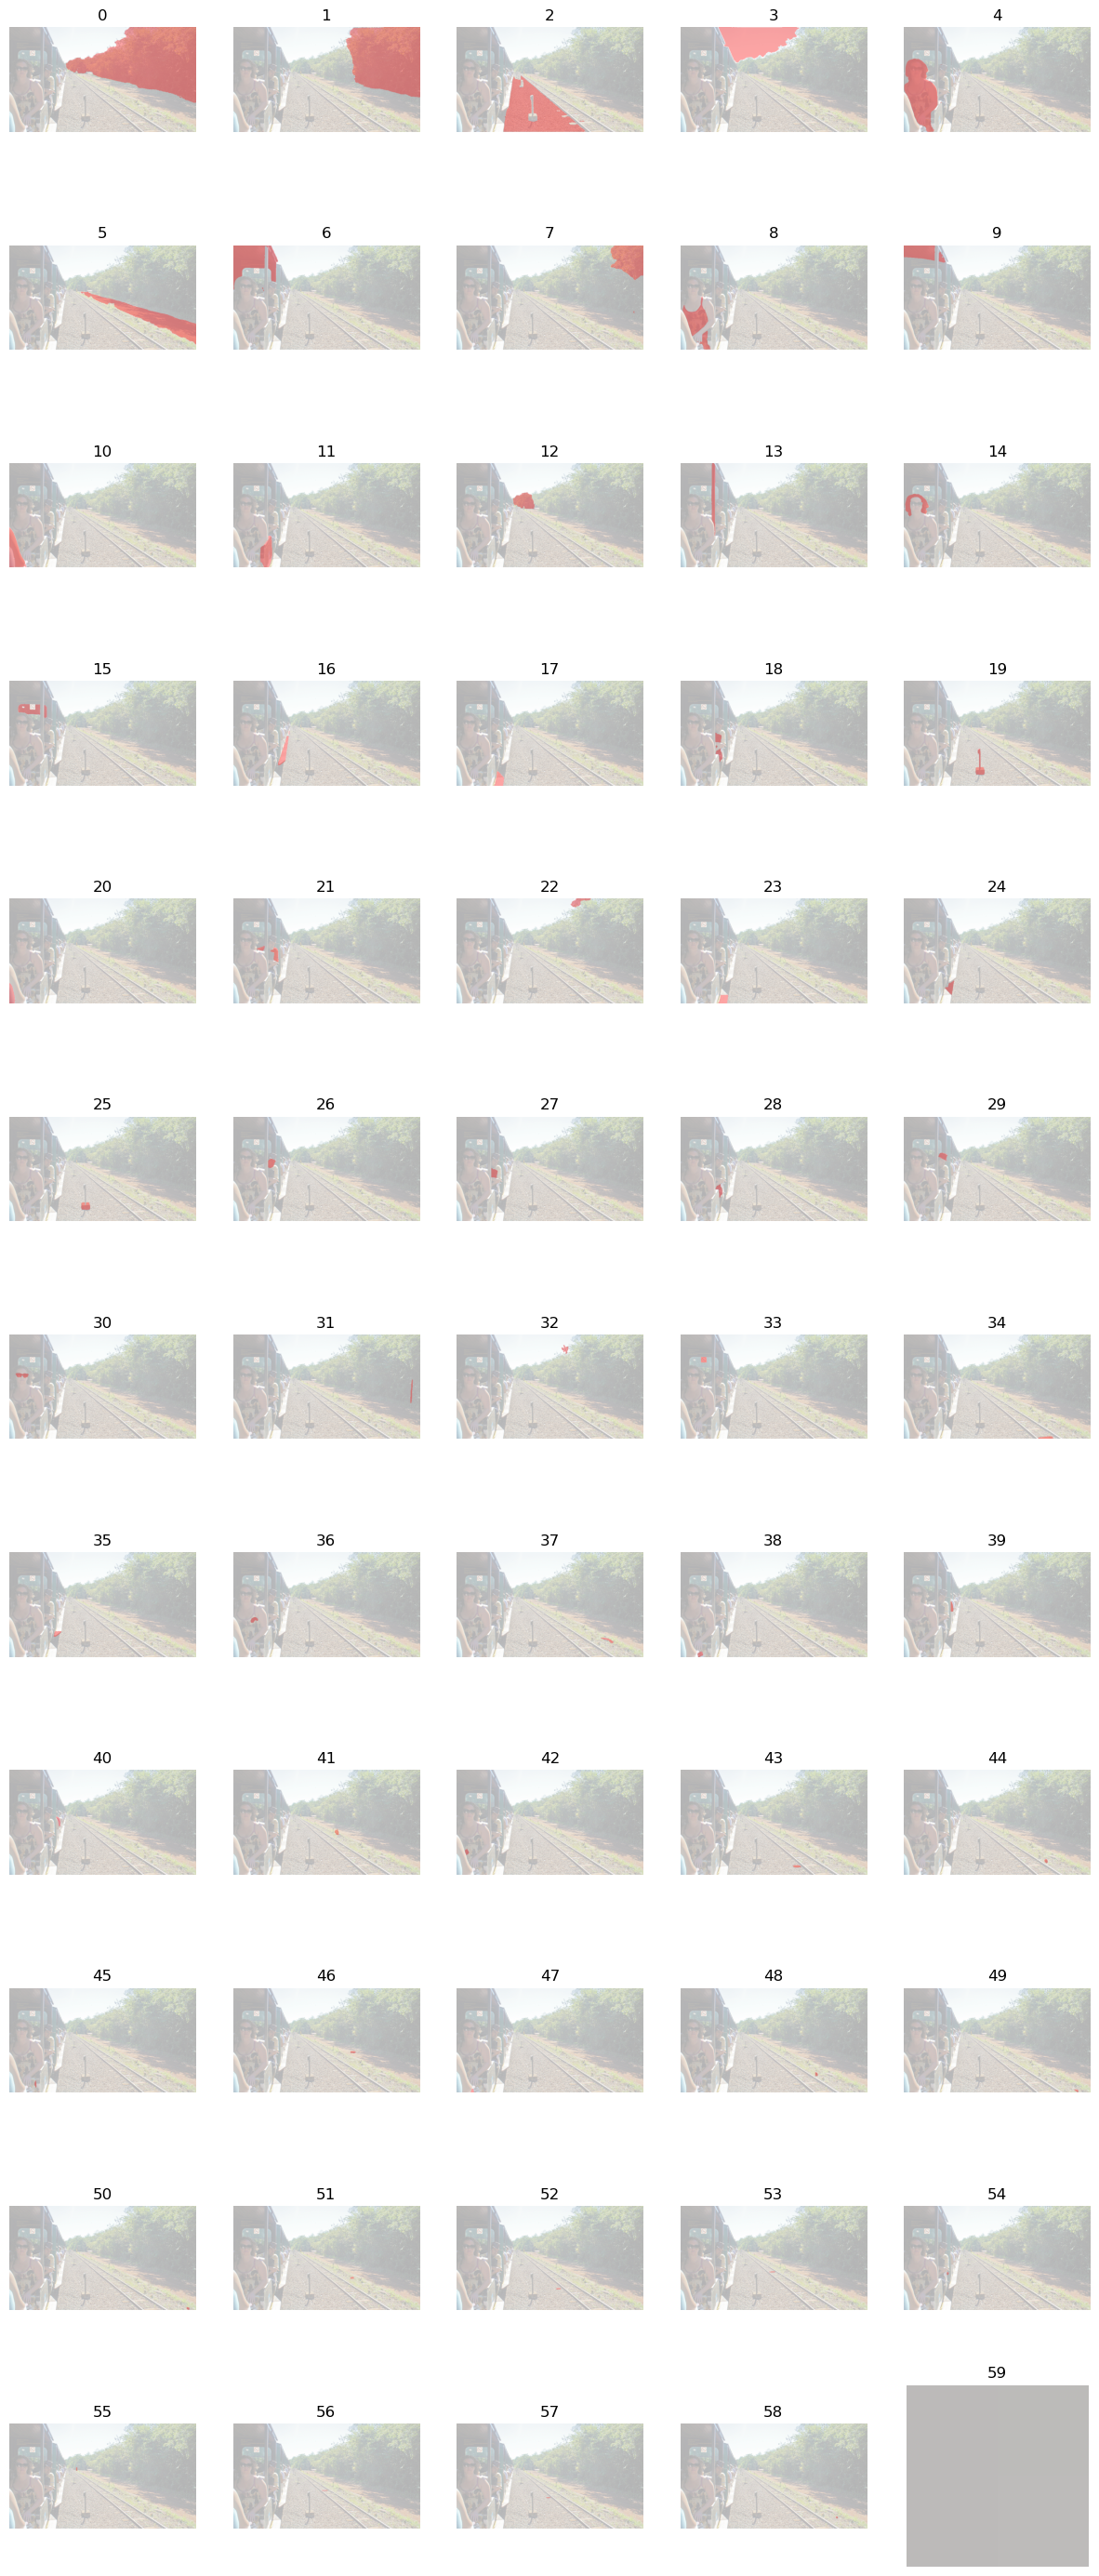

In [20]:
import math

# Calculate the number of rows needed
num_rows = math.ceil(len(ddup_masks) / 5)

# Create the subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

# Loop through the images and add them to the subplots
for i, mask in enumerate(ddup_masks):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(image, alpha=0.3)
    axs[row, col].imshow(show_anns(ddup_masks[i:i+1], 'red'))
    axs[row, col].axis('off')
    axs[row, col].set_title(i)
    

# Display the subplots
plt.show()

### GT Matching

In [ ]:
gt_feats = []

for gt_mask in gt_masks:
    max_iou = 0
    best_feat = None
    
    for mask_dict in ddup_masks:
        current_iou = iou(gt_mask, mask_dict['segmentation'])

        if current_iou > max_iou and current_iou > 0.5:
            max_iou = current_iou
            best_feat = np.array(mask_dict['feat'])
    
    gt_feats.append(best_feat)

# gt_feats = np.vstack(gt_feats)

In [ ]:
gt_feats

### Gather all data

In [ ]:
data['relations']

In [ ]:
len(gt_feats)

In [ ]:
list(psg_dataset.keys())[0]

In [ ]:
save_entry = {'id': id_num,
              'feat': gt_feats,
              'relations': data['relations'],
              'is_train': id_num not in psg_dataset_file['test_image_ids'],
             }

### Set training data

In [ ]:
print('done')

In [ ]:
with np.load('feats/save_dict_2346957.npz', allow_pickle=True) as data:
    print(len(data['feat']))
    print(data['relations'])
    for i, token in enumerate(data['feat']):
        print(i)
        print(token)

In [ ]:
import glob
import numpy as np
from tqdm import tqdm

# List all npz files in the feats directory
file_list = glob.glob("feats/save_dict_*.npz")

In [ ]:
len(file_list)

In [ ]:
train_data = []
train_label = []

test_data = []
test_label = []

for file in tqdm(file_list):
    with np.load(file, allow_pickle=True) as data:
        pairs_and_labels = []
        for relation in data['relations']:
            feat_id_1, feat_id_2, label = relation
            feature_1 = np.array(data['feat'][feat_id_1])
            feature_2 = np.array(data['feat'][feat_id_2])
            if feature_1.ndim > 0 and feature_2.ndim > 0:
                feature_pair = np.concatenate((feature_1, feature_2))
                if data['is_train']:
                    train_data.append(feature_pair)
                    train_label.append(label)
                else:
                    test_data.append(feature_pair)
                    test_label.append(label)

In [ ]:
train_data = np.array(train_data)
train_label = np.array(train_label)
print('train data size:', train_data.shape, 'label size: ', train_label.shape)

test_data = np.array(test_data)
test_label = np.array(test_label)
print('test data size:', test_data.shape, 'label size: ', test_label.shape)

In [ ]:
np.savez('relation_feat', 
         train_data=train_data, train_label=train_label, 
         test_data=test_data, test_label=test_label)

In [ ]:
# full data
for file in tqdm(file_list):
    with np.load(file, allow_pickle=True) as data:
        id_num = data['id']
        relation = data['relations']
        feature = data['feat']
        is_train = bool(data['is_train'])
        
    import pdb; pdb.set_trace();


In [ ]:
print('done')

### Inference

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_prob=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [23]:
# load model
input_size = 512
hidden_size = 256
num_classes = 56
model = MLP(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load("./share/model/best_model.pth"))

<All keys matched successfully>

### Segment with Prompt

In this section, we extract the mask feature as feats.

In [24]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

image_name = './images/dog.jpg'

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pilimage = Image.open(image_name)
width, height = pilimage.size
full_area = width * height

In [25]:
predictor = SamPredictor(build_sam(checkpoint="./segment_anything/checkpoints/sam_vit_h_4b8939.pth"))

In [26]:
predictor.set_image(image)

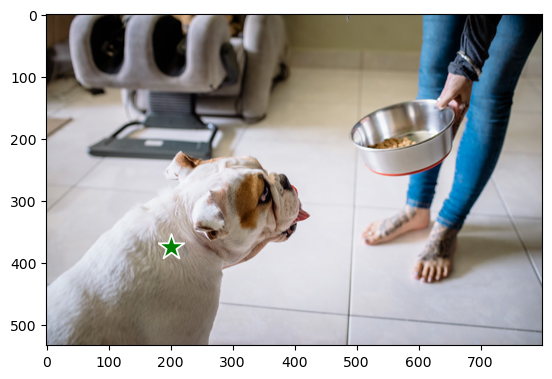

In [27]:
# dog
input_point = np.array([[200, 375]])
input_label = np.array([1])

# bowl
# input_point = np.array([[600, 200]])
# input_label = np.array([1])

# human
# input_point = np.array([[700, 50]])
# input_label = np.array([1])

# ground
# input_point = np.array([[500, 400]])
# input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
# plt.axis('off')
plt.show()

mask1, score1, logit1, feat1 = predictor.predict(point_coords=input_point,
                                                 point_labels=input_label,
                                                 multimask_output=False,)

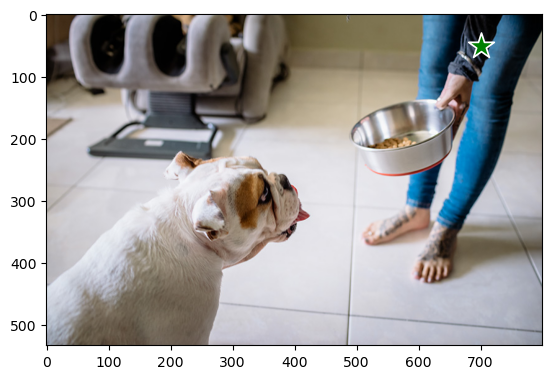

In [35]:
# dog
# input_point = np.array([[200, 375]])
# input_label = np.array([1])

# bowl
# input_point = np.array([[600, 200]])
# input_label = np.array([1])

# human
input_point = np.array([[700, 50]])
input_label = np.array([1])

# # sofa
# input_point = np.array([[150, 100]])
# input_label = np.array([1])

# # ground
# input_point = np.array([[500, 400]])
# input_label = np.array([1])

plt.imshow(image)
show_points(input_point, input_label, plt.gca())
# plt.axis('off')
plt.show()

mask2, score2, logit2, feat2 = predictor.predict(point_coords=input_point,
                                                 point_labels=input_label,
                                                 multimask_output=False,)

In [36]:
concat_input = torch.cat((feat1, feat2), dim=2)

In [37]:
relation_classes = [
    'over', 'in front of', 'beside', 'on', 'in', 'attached to', 'hanging from', 'on back of', 'falling off', 
    'going down', 'painted on', 'walking on', 'running on', 'crossing', 'standing on', 'lying on', 'sitting on', 
    'flying over', 'jumping over', 'jumping from', 'wearing', 'holding', 'carrying', 'looking at', 'guiding', 
    'kissing', 'eating', 'drinking', 'feeding', 'biting', 'catching', 'picking', 'playing with', 'chasing', 
    'climbing', 'cleaning', 'playing', 'touching', 'pushing', 'pulling', 'opening', 'cooking', 'talking to', 
    'throwing', 'slicing', 'driving', 'riding', 'parked on', 'driving on', 'about to hit', 'kicking', 'swinging', 
    'entering', 'exiting', 'enclosing', 'leaning on']

In [38]:
output = model(concat_input)
topk_indices = torch.argsort(-output).flatten()

In [39]:
top3_rel = [relation_classes[indice] for indice in topk_indices][:5]

In [40]:
top3_rel

['holding', 'beside', 'attached to', 'looking at', 'in front of']

In [41]:
sigmoid_output = torch.sigmoid(output)
rounded_output = torch.round(sigmoid_output * 100) / 100
print(rounded_output)

tensor([[[0.2600, 0.9600, 0.9900, 0.6600, 0.2700, 0.9700, 0.1300, 0.0100,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0100, 0.0000, 0.2000, 0.2700,
          0.0400, 0.0000, 0.0000, 0.0100, 0.8900, 1.0000, 0.8900, 0.9700,
          0.0000, 0.0100, 0.8800, 0.1400, 0.3300, 0.9100, 0.3500, 0.0000,
          0.7300, 0.0300, 0.0000, 0.0100, 0.6000, 0.6800, 0.0000, 0.1200,
          0.0000, 0.0000, 0.3000, 0.1100, 0.0500, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0100, 0.0000, 0.2300, 0.0000, 0.0100, 0.1000, 0.5800]]],
       grad_fn=<DivBackward0>)


In [43]:
sam_masks = mask_generator.generate(image)
filtered_masks = [d for d in sam_masks if d['area'] > 0.03 * full_area]
filtered_masks = sort_and_deduplicate(filtered_masks)
print('number of masks left:', len(filtered_masks))

number of masks left: 8


In [42]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show() 

NameError: name 'masks' is not defined